In [32]:
from pybit.unified_trading import HTTP
import pandas as pd
from datetime import datetime, timedelta

In [33]:
session = HTTP(testnet=False)

## Получаем актуальную цену криптовалюты

В примере BTC к USDT

In [34]:
# Получение тикера для BTCUSDT
ticker_data = session.get_tickers(category="linear", symbol="BTCUSDT")

# Извлечение последней цены
if ticker_data["retCode"] == 0:
    last_price = float(ticker_data["result"]["list"][0]["lastPrice"])
    print(f"Актуальная цена BTC/USDT: {last_price}")
else:
    print(f"Ошибка при получении данных: {ticker_data['retMsg']}")

Актуальная цена BTC/USDT: 104206.0


In [35]:
ticker_data

{'retCode': 0,
 'retMsg': 'OK',
 'result': {'category': 'linear',
  'list': [{'symbol': 'BTCUSDT',
    'lastPrice': '104206.00',
    'indexPrice': '104246.11',
    'markPrice': '104206.00',
    'prevPrice24h': '103699.40',
    'price24hPcnt': '0.004885',
    'highPrice24h': '104986.70',
    'lowPrice24h': '102880.00',
    'prevPrice1h': '103833.60',
    'openInterest': '47402.722',
    'openInterestValue': '4939648048.73',
    'turnover24h': '6007856318.7384',
    'volume24h': '57838.5090',
    'fundingRate': '0.0001',
    'nextFundingTime': '1746979200000',
    'predictedDeliveryPrice': '',
    'basisRate': '',
    'deliveryFeeRate': '',
    'deliveryTime': '0',
    'ask1Size': '4.361',
    'bid1Price': '104206.00',
    'ask1Price': '104206.10',
    'bid1Size': '6.571',
    'basis': '',
    'preOpenPrice': '',
    'preQty': '',
    'curPreListingPhase': ''}]},
 'retExtInfo': {},
 'time': 1746956285086}

## Прогнозирование и обучение моделей

### Получение исторических данных

In [36]:
def get_historical_data(symbol: str, days: int = 200):
    # Автоматически добавляем USDT для корректности запроса, если не указан
    if not symbol.upper().endswith("USDT"):
        symbol = symbol.upper() + "USDT"

    session = HTTP(testnet=False)
    end_time = int(datetime.now().timestamp() * 1000)
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)

    response = session.get_kline(
        category="linear",
        symbol=symbol,
        interval="D",
        start=start_time,
        end=end_time,
        limit=days
    )

    raw = response["result"]["list"]
    df = pd.DataFrame(raw, columns=["timestamp", "open", "high", "low", "close", "volume", "turnover"])
    df["timestamp"] = pd.to_datetime(df["timestamp"].astype(int), unit="ms")
    for col in ["open", "high", "low", "close", "volume", "turnover"]:
        df[col] = df[col].astype(float)

    df["target"] = df["close"].shift(-1)
    df = df.dropna()
    df = df.sort_values("timestamp")  # сортировка по времени
    return df


In [37]:
get_historical_data("BTCUSDT",200)

,timestamp,open,high,low,close,volume,turnover,target
198,2024-10-25,68171.2,68755.0,65524.5,66666.8,183971.112,1.237935e+10,68171.2
197,2024-10-26,66666.8,67442.7,66408.4,67069.1,44536.687,2.980568e+09,66666.8
196,2024-10-27,67069.1,68311.6,66905.2,68001.1,47106.670,3.185701e+09,67069.1
195,2024-10-28,68001.1,70449.9,67571.4,69947.6,147940.160,1.020482e+10,68001.1
194,2024-10-29,69947.6,73681.8,69735.4,72757.5,205358.993,1.477605e+10,69947.6
...,...,...,...,...,...,...,...,...
4,2025-05-07,96799.0,97700.0,95724.2,96988.1,93114.149,9.009073e+09,96799.0
3,2025-05-08,96988.1,104253.8,96832.1,103240.0,152859.152,1.533863e+10,96988.1
2,2025-05-09,103240.0,104330.1,102264.1,102931.2,87154.724,8.979125e+09,103240.0
1,2025-05-10,102931.2,104986.7,102772.0,104782.3,47626.468,4.936954e+09,102931.2


### Обучение модели

In [43]:
def train_model(df: pd.DataFrame, model_name: str):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error
    import xgboost as xgb
    import lightgbm as lgb
    from prophet import Prophet

    df = df.dropna().sort_values("timestamp").reset_index(drop=True)

    features = ["open", "high", "low", "close", "volume", "turnover"]

    if model_name == "prophet":
        df_p = df[["timestamp", "close"]].rename(columns={"timestamp": "ds", "close": "y"})
        test_size = int(len(df_p) * 0.2)
        train_df = df_p[:-test_size]
        test_df = df_p[-test_size:]

        model = Prophet()
        model.fit(train_df)

        future = model.make_future_dataframe(periods=test_size)
        forecast = model.predict(future)

        y_true = test_df["y"].values
        y_pred = forecast[["ds", "yhat"]].tail(test_size)["yhat"].values

        mae = mean_absolute_error(y_true, y_pred)
        print(f"📉 PROPHET MAE на тестовой выборке: {mae:.2f}")
        return {"prophet": model}

    # Подготовка обучающих данных для каждой целевой переменной
    models = {}
    model_class = {
        "random_forest": RandomForestRegressor,
        "xgboost": xgb.XGBRegressor,
        "lightgbm": lgb.LGBMRegressor,
    }

    if model_name not in model_class:
        raise ValueError("Модель не поддерживается")

    # Обучение моделей для признаков: open, high, low, volume, turnover
    for target in ["open", "high", "low", "volume", "turnover"]:
        X = df[features]
        y = df[target].shift(-1)  
        X, y = X[:-1], y[:-1]    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        model = model_class[model_name](n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        print(f"{model_name.upper()} → {target} MAE: {mae:.2f}")

        models[target] = model

    # target = close (shift -1)
    X = df[features]
    y = df["close"].shift(-1)
    X, y = X[:-1], y[:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    close_model = model_class[model_name](n_estimators=100, random_state=42)
    close_model.fit(X_train, y_train)
    y_pred = close_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name.upper()} → close MAE: {mae:.2f}")

    models["close"] = close_model

    return models


In [44]:
models = ["random_forest", "xgboost", "lightgbm", "prophet"]

df = get_historical_data("BTC", days=200)  # для примера

trained_models = {}
for model_name in models:
    print(f"\n Обучаем модель: {model_name}")
    model = train_model(df, model_name)
    trained_models[model_name] = model


 Обучаем модель: random_forest
RANDOM_FOREST → open MAE: 426.19
RANDOM_FOREST → high MAE: 1353.17
RANDOM_FOREST → low MAE: 1248.03
RANDOM_FOREST → volume MAE: 36984.73
RANDOM_FOREST → turnover MAE: 3090734752.91
RANDOM_FOREST → close MAE: 1832.80

 Обучаем модель: xgboost
XGBOOST → open MAE: 357.02
XGBOOST → high MAE: 1359.79
XGBOOST → low MAE: 1456.15
XGBOOST → volume MAE: 39325.18
XGBOOST → turnover MAE: 3492209332.41
XGBOOST → close MAE: 2030.19

 Обучаем модель: lightgbm
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 324
[LightGBM] [Info] Number of data points in the train set: 158, number of used features: 6
[LightGBM] [Info] Start training from score 91985.567791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

19:38:46 - cmdstanpy - INFO - Chain [1] start processing
19:38:46 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LIGHTGBM → turnover MAE: 3566123684.40
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the

### Прогноз с авторекурсией

In [45]:
def forecast_n_days(models, df: pd.DataFrame, model_name: str, n_days: int):
    if model_name == "prophet":
        model = models["prophet"]
        future = model.make_future_dataframe(periods=n_days)
        forecast = model.predict(future)
        result = forecast[["ds", "yhat"]].tail(n_days)
        result.columns = ["timestamp", "predicted_close"]
        return result

    # Инициализация
    preds = []
    last_row = df.iloc[-1:].copy()

    for _ in range(n_days):
        # Предсказание фичей
        next_features = {}
        for feat in ["open", "high", "low", "volume", "turnover"]:
            X_feat = last_row[["open", "high", "low", "close", "volume", "turnover"]].values
            y_feat = models[feat].predict(X_feat)[0]
            next_features[feat] = y_feat

        # Формирование строки с фичами
        feature_row = {
            "open": next_features["open"],
            "high": next_features["high"],
            "low": next_features["low"],
            "close": last_row["close"].values[0],  # предыдущее закрытие
            "volume": next_features["volume"],
            "turnover": next_features["turnover"],
        }
        X_close = pd.DataFrame([feature_row])[["open", "high", "low", "close", "volume", "turnover"]]
        y_close = models["close"].predict(X_close)[0]
        preds.append(y_close)

        # Создание новой строки на основе предсказаний
        new_row = pd.DataFrame([{
            "timestamp": last_row["timestamp"].values[0] + pd.Timedelta(days=1),
            "open": next_features["open"],
            "high": next_features["high"],
            "low": next_features["low"],
            "close": y_close,
            "volume": next_features["volume"],
            "turnover": next_features["turnover"],
        }])

        last_row = new_row

    future_dates = pd.date_range(start=df["timestamp"].iloc[-1] + pd.Timedelta(days=1), periods=n_days)
    return pd.DataFrame({"timestamp": future_dates, "predicted_close": preds})


### Запускаем цикл прогнозирования

In [46]:
def predict_token_price(symbol: str, model_name: str, n_days: int):
    assert model_name in ["random_forest", "xgboost", "lightgbm", "prophet"], "Неподдерживаемая модель"
    assert 1 <= n_days <= 30, "Горизонт прогноза должен быть от 1 до 30 дней"

    print(f"Загружаем данные по {symbol}...")
    df = get_historical_data(symbol, days=200)

    print(f"Обучаем модель {model_name}...")
    models = train_model(df, model_name)

    print(f"Делаем прогноз на {n_days} дней...")
    forecast = forecast_n_days(models, df, model_name, n_days)

    # Построение графика
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.plot(df["timestamp"], df["close"], label="Историческая цена")
    plt.plot(forecast["timestamp"], forecast["predicted_close"], label="Прогноз")
    plt.xlabel("Дата")
    plt.ylabel("Цена " + symbol.upper() + "/USDT")
    plt.title(f"Прогноз цены {symbol.upper()}/USDT с помощью {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast


### Пример

Загружаем данные по BTCUSDT...
Обучаем модель xgboost...
XGBOOST → open MAE: 357.02
XGBOOST → high MAE: 1359.79
XGBOOST → low MAE: 1456.15
XGBOOST → volume MAE: 39325.16
XGBOOST → turnover MAE: 3492206999.71
XGBOOST → close MAE: 2030.19
Делаем прогноз на 7 дней...


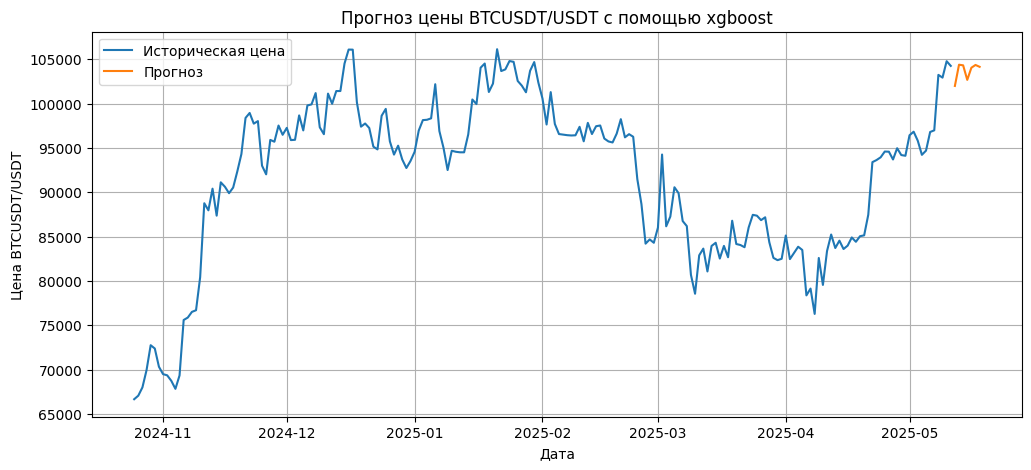

,timestamp,predicted_close
0,2025-05-12,101992.234375
1,2025-05-13,104385.507812
2,2025-05-14,104317.125000
3,2025-05-15,102677.218750
4,2025-05-16,104047.835938
5,2025-05-17,104359.328125
6,2025-05-18,104147.703125


In [47]:
predict_token_price("BTCUSDT", "xgboost", 7)